In [1]:
import numpy as np
import pandas as pd
import soundfile as sf
import simpleaudio as sa
import sounddevice as sd
from scipy.io import wavfile
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['font.weight'] = 'bold'
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['axes.titleweight'] = 'bold'

In [2]:
class SignalTB:
    """
        My signal toolbox (SignalTB)!
    """
    
    def __init__(self, x, fs):
        """
        Arguments:
            x: Time Series
            fs: Sample Frequency
        """
        self.fs = fs; # [hz
        self.x = x    # time domain series
        self.X = None # frequency domain series
        self.signals = None #useful container
        
        self.N = self.x.shape[0]   # number of samples
        self.L = self.x.index[-1] - self.x.index[0]   # total time of signal [s]
        self.dt = self.L/self.N  # [s]
        self.df = self.fs/self.N
        
    def my_fft(self):
        """
        Description:
            This method calculates the fft of a time domain signal using numpy's fft function and 
        adjusting it appropriately to multiplies it by dt.
        
        Returns:
            Series of frequency domain signal
        """
        freq = np.arange(-np.ceil(self.N/2)+1,
                         np.floor(self.N/2)+1) * self.df
        X = np.fft.fft(a=self.x.values, n=None, axis=-1, norm=None) * self.dt
        X = np.concatenate((X[self.N//2+1:],
                            X[0:self.N//2+1])) # rearrange the frequencies from standard form to sequential. Remember that 1:self.N//2 does not grab that second index value
        self.parseval_thrm(self.x,X)  #check Parsevals thrm
        X = pd.Series(data=X,
                      index=freq,
                      name='frequency domain signal')
        self.X = X
        self.signals = [self.x, self.X]
        return X
    
    def my_ifft(self):
        """
        Description:
            This method calculates the ifft of a time domain signal using numpy's ifft function and 
        adjusting it appropriately to multiplies it by dt.
        
        Returns:
            Series of frequency domain signal
        """
        t = np.linspace(start=self.x.index[0], stop=self.x.index[-1], num=self.N, endpoint=True)
        X = self.X.values # these are in sequential, non standard form
        X = np.concatenate((X[int(np.ceil(self.N/2))-1:],
                            X[0:int(np.ceil(self.N/2))-1])) #put the fft values in standard form so ifft can accept it
        x = np.fft.ifft(a=X, n=None, axis=-1, norm=None) / self.dt
        #display(x)
        self.parseval_thrm(x,self.X)  #check Parsevals thrm
        self.parseval_thrm(x,X)  #check Parsevals thrm
        x = pd.Series(data=x,
                      index=t,
                      name='time domain signal')
        self.signals = [self.x, self.X, x]
        return x
    
    def parseval_thrm(self, x, X):
        """
        Description:
             Checks to make sure Parseval's Theorem holds between a time domain and FFT holds true

        Arguments:
            x: time domain signal
            X: frequency domain signal
        """
        td = round((x**2).sum() * self.dt, 1)
        fd = round((np.absolute(X)**2).sum() * self.df, 1)
        assert td == fd , "Parseval Theorem not satisfied: {} != {}, DFFT is incorrect".format(td,fd)
    
    def plot_signals(self):
        """
        Description:
            Plots all of the signals in the self.signals container
            
        Returns:
            Nothing
        """
        figs = []
        for i, sig in enumerate(self.signals):
            fig = plt.figure(figsize=(10,5))
            if sig.name == 'time domain signal': plt.title(sig.name); plt.ylabel('x(t)'); plt.xlabel('t [s]');plt.grid()
            elif sig.name == 'frequency domain signal':
                plt.title(sig.name); plt.ylabel('X(f)'); plt.xlabel('f [Hz]');plt.grid()
                sig = np.absolute(sig) # compute the magnitude of the complex number to plot its magnitude
            sig.plot(); figs.append(fig)
        return figs
        
    #Useful functions to generate signals
    @staticmethod
    def sin(A,f,L,N):
        """
        Arguments:
            A: Amplitude
            f: Frequency of signal [hz]
            L: Total length of time [s]
            N: Number of points
            
        Returns:
            Series
        """
        t = np.linspace(start=0, stop=L, num=N, endpoint=True,dtype=float)
        return pd.Series(data=A*np.sin(2*np.pi*f*t),
                         index=t,
                         name='time domain signal')
    
    @staticmethod
    def randn_sig(L,N):
        """
        Arguments:
            L : Total length of time [s]
            N : Number of points
            
        Returns:
            Series
        """
        return pd.Series(data=np.random.randn(N,),
                         index=np.linspace(start=0, stop=L, num=N, endpoint=True),
                         name='time domain signal')

# Question 1

/home/m4rz910/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


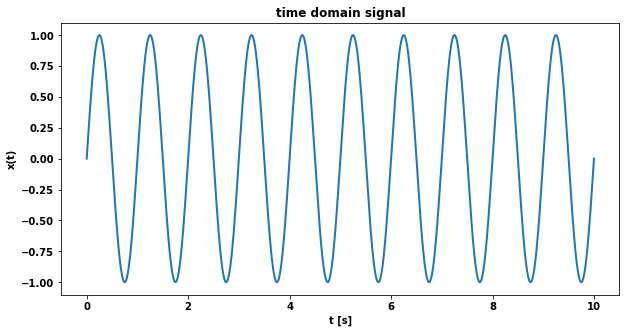

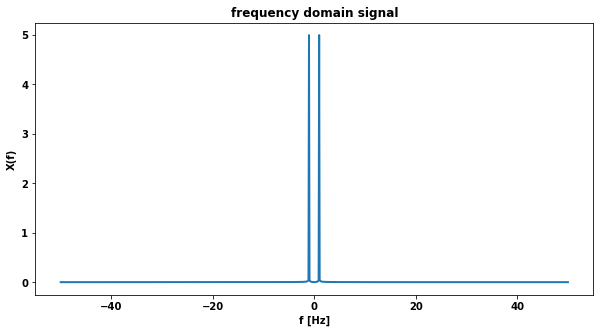

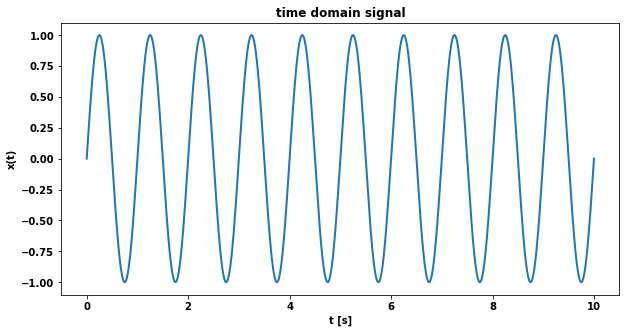

In [3]:
N = 1000
L = 10 # [s]
x = SignalTB.sin(A = 1, f = 1, N = N, L = L)
s = SignalTB(x=x,fs=N/L)
fd = s.my_fft();
x2 = s.my_ifft()
s.plot_signals();

/home/m4rz910/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/m4rz910/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


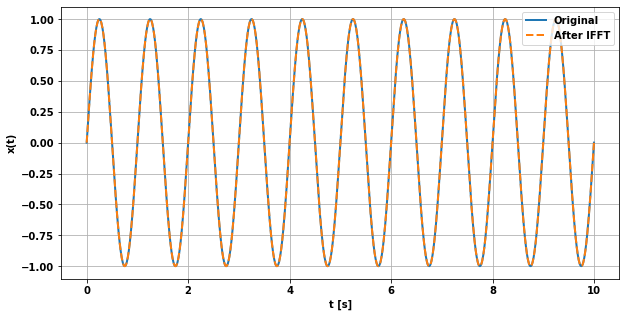

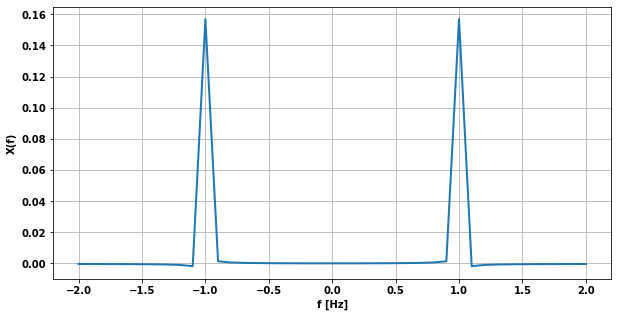

In [5]:
#FORGOT TO TAKE ABS OF FD
fig = plt.figure(figsize=(10,5))
plt.plot(x)
plt.plot(x2, '--')
plt.ylabel('x(t)'); plt.xlabel('t [s]'); plt.grid(); plt.legend(['Original', 'After IFFT'], loc = 'upper right')
fig.savefig('./plots/time.png', dpi=300, bbox_inches='tight');

fig= plt.figure(figsize=(10,5))
fd.loc[-2:2].plot(); plt.ylabel('X(f)'); plt.xlabel('f [Hz]'); plt.grid()
fig.savefig('./plots/freq.png', dpi=300, bbox_inches='tight');

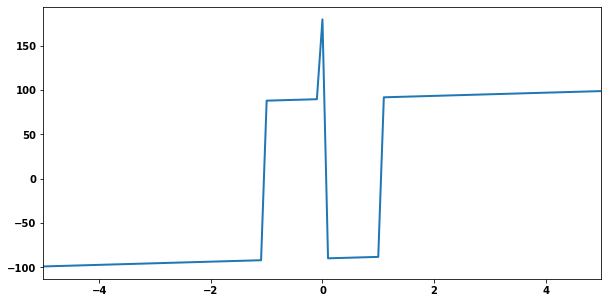

In [242]:
phase = pd.Series(data=pd.np.angle(fd, deg=True),
                  index=fd.index)
phase[-5:5].plot(figsize=(10,5))

# Question 2

In [187]:
# fs = 48000
# duration = 5  # seconds
# myrecording = sd.rec(int(duration * fs), samplerate=fs, channels=1)
# sd.wait()

In [217]:
# sd.play(myrecording)
# wavfile.write('guitar.wav', fs, myrecording.ravel()) # saves it as an uncompressed wave file

In [220]:
filename = './construction.wav'
wave_obj = sa.WaveObject.from_wave_file(filename)
play_obj = wave_obj.play()
play_obj.wait_done()

/home/m4rz910/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


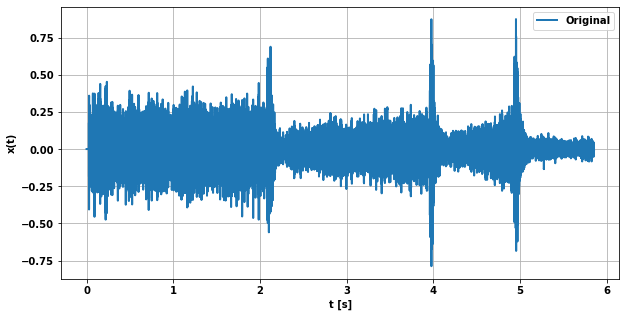

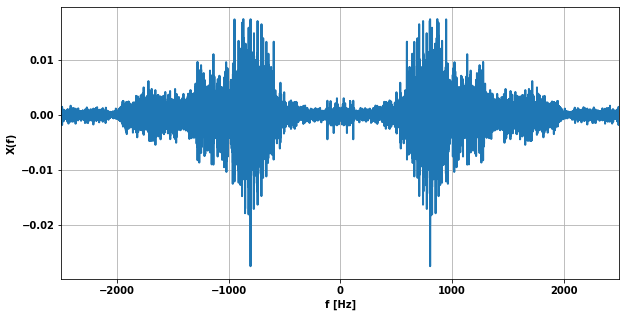

In [250]:
data, fs = sf.read('./construction.wav')
N = len(data)
L = N/fs
x = pd.Series(data=data,
              index=np.linspace(start=0, stop=L, num=N, endpoint=True),
              name='time domain signal')
#x = x.loc[2:2.6] #g
s = SignalTB(x=x,fs=fs)
fd = s.my_fft();
x2 = s.my_ifft()

fig = plt.figure(figsize=(10,5))
plt.plot(x)
#plt.plot(x2, '--')
plt.ylabel('x(t)'); plt.xlabel('t [s]'); plt.grid(); plt.legend(['Original', 'After IFFT'], loc = 'upper right')
fig.savefig('./plots/2_time.png', dpi=300, bbox_inches='tight');

fig= plt.figure(figsize=(10,5))
fd.loc[-2500:2500].plot(); plt.ylabel('X(f)'); plt.xlabel('f [Hz]'); plt.grid()
fig.savefig('./plots/2_freq.png', dpi=300, bbox_inches='tight');

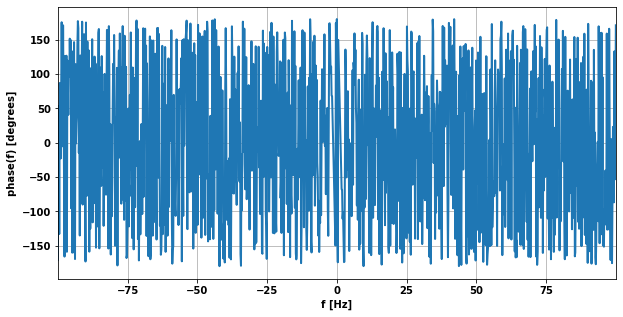

In [248]:
phase = pd.Series(data=pd.np.angle(fd, deg=True),
              index=fd.index)
fig= plt.figure(figsize=(10,5))
phase.loc[-100:100].plot(); plt.ylabel('phase(f) [degrees]'); plt.xlabel('f [Hz]'); plt.grid()
fig.savefig('./plots/2_phase.png', dpi=300, bbox_inches='tight');

# Question 3

In [ ]:
filename = './EID 465 - HW 1 - EFP.wav
wave_obj = sa.WaveObject.from_wave_file(filename)
play_obj = wave_obj.play()
play_obj.wait_done()

/home/m4rz910/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


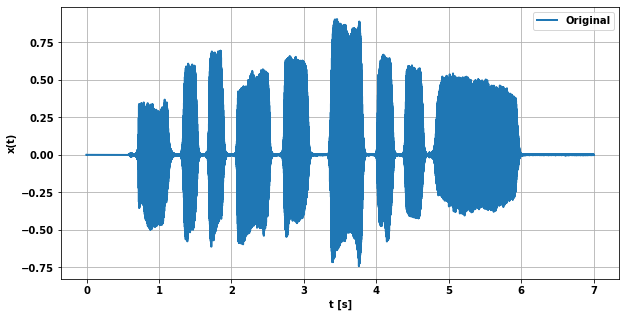

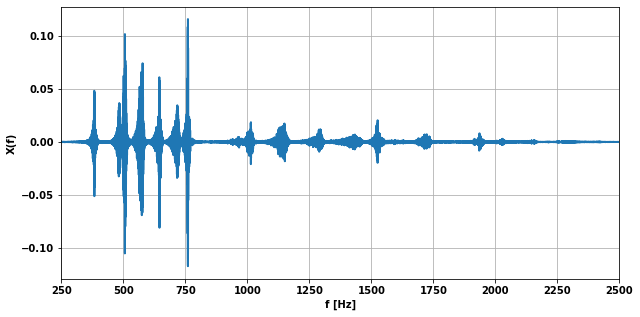

In [234]:
data, fs = sf.read('./EID 465 - HW 1 - EFP.wav')
N = len(data)
L = N/fs
x = pd.Series(data=data,
              index=np.linspace(start=0, stop=L, num=N, endpoint=True),
              name='time domain signal')
#x = x.loc[2:2.6] #g
s = SignalTB(x=x,fs=fs)
fd = s.my_fft();
x2 = s.my_ifft()

fig = plt.figure(figsize=(10,5))
plt.plot(x)
#plt.plot(x2, '--')
plt.ylabel('x(t)'); plt.xlabel('t [s]'); plt.grid(); plt.legend(['Original', 'After IFFT'], loc = 'upper right')
fig.savefig('./plots/3_time.png', dpi=300, bbox_inches='tight');

fig= plt.figure(figsize=(10,5))
fd.loc[250:2500].plot(); plt.ylabel('X(f)'); plt.xlabel('f [Hz]'); plt.grid()
fig.savefig('./plots/3_freq.png', dpi=300, bbox_inches='tight');

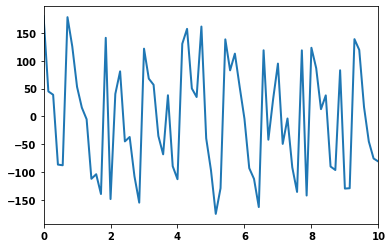

In [237]:
phase = pd.Series(data=pd.np.angle(fd, deg=True),
              index=fd.index)
phase.loc[0:10].plot()